In [53]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

logging.basicConfig(format='%(message)s', level=logging.INFO)

In [54]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = [200]
network_size = [25]
total_nodes = 300
new_network = True
model = "AI_model/models_joo_kai/main_network_parameter_set_1.h5"
trial = 5

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]

result_head_path = '/home/22701889/Documents/MTDSim'


In [55]:

class Experiment:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.model = model
        self.trial = trial
        
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size




    def run_trials(self, scheme):
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = single_mtd_simulation("nomtd", [None], 
                                                         mtd_interval=self.mtd_interval,network_size=self.network_size) 
            elif scheme == 'mtd_ai':
                try:
                    mtd = mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, 
                                                             mtd_interval=self.mtd_interval,network_size=self.network_size )  
                except:
                    continue  
            else:
                mtd = specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)
        return 
    
    def get_result(self, path,scheme):
        path = f'{path}/experiments/experimental_data/results/{scheme}.csv'
        df = pd.read_csv(path)
        return df
    def get_result_checkpoint_median(self, path, scheme,checkpoints = 9):

        df = self.get_result(path, scheme).drop('Name', axis = 1)
        df['group'] = df.index // checkpoints
        # Group by the new column and calculate median
        df = df.groupby('group').median().reset_index(drop=True)
        # Drop the 'group' column if you don't need it in the result
        df = df.drop(columns='group', errors='ignore')
        return df

    def get_result_stats(self, checkpoint_medians,stats_type = 'median'):
        if stats_type == 'median':
            return checkpoint_medians.median()
        return checkpoint_medians.std()
    
    def raw_result_stats_pipeline(self, scheme,run_trial = False, stats_type = 'median'):
        if run_trial:
            self.run_trials(scheme)
        checkpoint_medians = self.get_result_checkpoint_median(result_head_path,scheme)
        result = self.get_result_stats(checkpoint_medians,stats_type = stats_type)
        return result
        
    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {"MEF"}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure', 'ASR', 'ROA', 'exposed_endpoints', "risk"}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics

    def scaled_pipeline(self, scheme,run_trial = False, stats_type = 'median'):
        nomtd_result = self.raw_result_stats_pipeline('nomtd',run_trial, stats_type)
        scheme_result = self.raw_result_stats_pipeline(scheme,run_trial, stats_type)
        scaled_scheme_result = self.scale_metrics(scheme_result.to_dict(), nomtd_result.to_dict())
        return scaled_scheme_result


In [56]:
result = Experiment(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, model, trial)

In [57]:
scaled_scheme = result.scaled_pipeline( 'mtd_ai',run_trial = False, stats_type = 'median')

In [58]:


class RadarPlot(Experiment):
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial):
        super().__init__(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial)

    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()




In [59]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial)

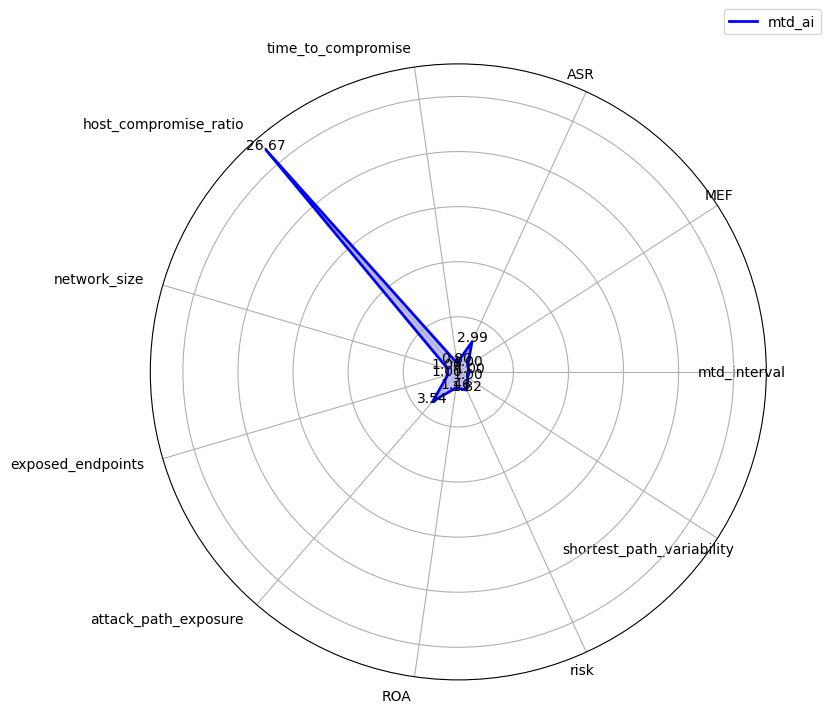

In [60]:
radar.plot_single_radar(scaled_scheme, 'mtd_ai', std_dev_values=None)